In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import laspy
from shapely import contains_xy
from scipy.stats import gaussian_kde

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds220-env/share/proj failed


### Shapefile of Plot
***

<Axes: >

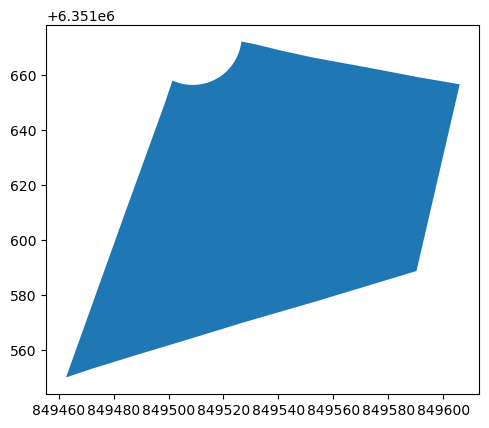

In [3]:
# Load Data For Cote-du-Rhone
fp = os.path.join("..", "data", "AocDep84.shp")
vine_data = gpd.read_file(fp)

# Filter to Municiplity of Sainte-C ́ecile-les-Vignes
stcec = vine_data[vine_data.IDU.str.slice(0, 5).str.contains("84106")]

# Plot Located at 1059 Route de Boll`ene
parcels = stcec[stcec.IDU == "841060000E0325"]

# Transform parcels to match LiDAR CRS (LAMB93 = EPSG:2154)
parcels = parcels.to_crs(epsg=2154)

parcels.plot()

### Load in LiDAR Data
***

In [4]:
# Read in LIDAR Data and Select Points
fp = os.path.join("..", "data", "LHD_FXX_0849_6352_PTS_LAMB93_IGN69.copc.laz")
lidar_data = laspy.read(fp)
points_x, points_y = lidar_data.x, lidar_data.y

# Select polygon
SEL = parcels.geometry.iloc[0]  # adjust index or filter as needed

# Create mask from selection
mask = contains_xy(SEL, lidar_data.x, lidar_data.y)

# Create Clip of Lidar Data Within Mask
las_clip = laspy.create(point_format=lidar_data.header.point_format, file_version=lidar_data.header.version)
las_clip.points = lidar_data.points[mask]

# Plot of raw LiDAR data
fig, ax = plt.subplots(figsize=(10, 10))

# Plot points
sc = ax.scatter(las_clip.x, las_clip.y, c=las_clip.z, s=0.01, cmap='terrain')
plt.colorbar(sc, label='Elevation (m)')

# Overlay polygon boundary
parcels.boundary.plot(ax=ax, color='black', linewidth=2)

ax.set_aspect('equal')
plt.show()

### 3D Plot of LiDAR Data
***

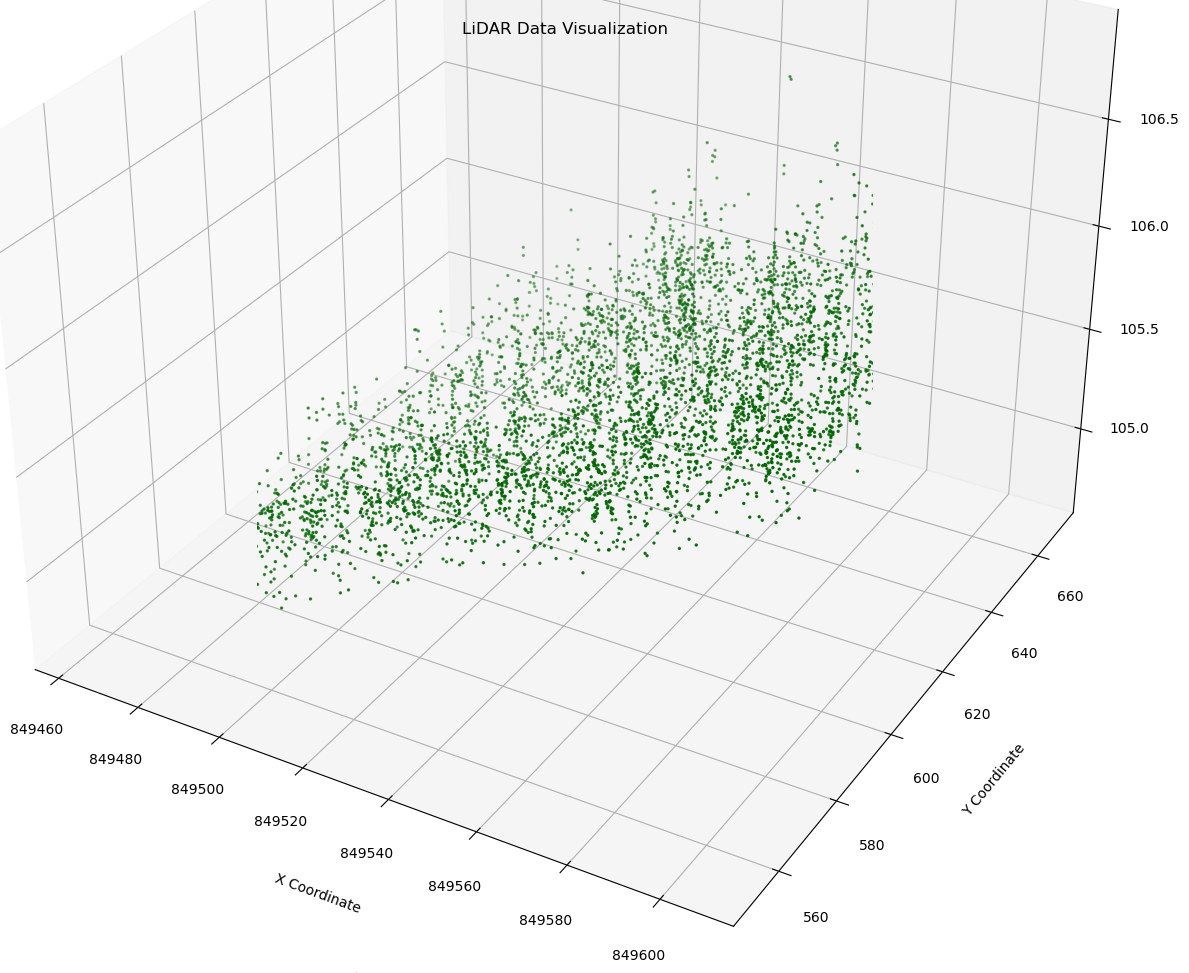

In [107]:
# Color Map
color_map = {
    1: 'grey',
    2: '#8B4513',
    3: '#00FF00', # Weeds
    4: '#006400', # Vines
    5: '#008000', # Trees
    6: 'pink',
    65: 'grey'
}

# Access the X, Y, and Z coordinates
x = las_clip.x
y = las_clip.y
z = las_clip.z

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = [color_map[val] for val in las_clip.classification]

# Scatter plot the points, coloring by elevation (Z)
ax.scatter(x, y, z, c=colors, s=2) # s=1 sets the point size

# Set labels for the axes
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Height (Z)')
ax.set_title('LiDAR Data Visualization')
ax.set_box_aspect(None, zoom=2) 
plt.show()

### Plot Containing Plants 1 - 2 Meters in Height
***

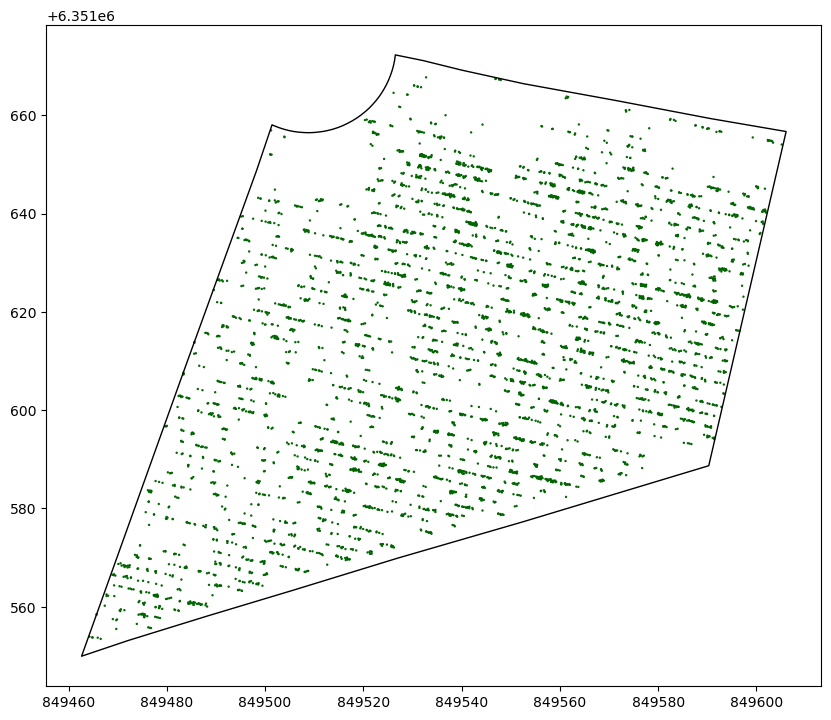

In [8]:
las_clip = las_clip[(las_clip.classification == 4)]


colors = [color_map[val] for val in las_clip.classification]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot points
sc = ax.scatter(las_clip.x, las_clip.y, c=colors, s=0.5)

# Overlay polygon boundary
parcels.boundary.plot(ax=ax, color='black', linewidth=1)

ax.set_aspect('equal')
plt.show()

### Function That Clusters Points to Find Individual Plants
***

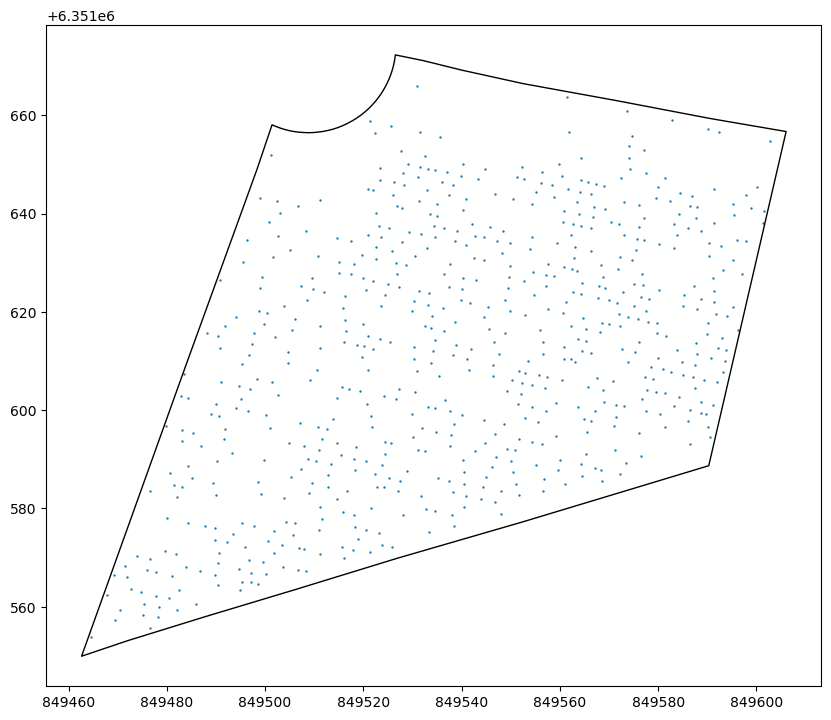

In [110]:
import open3d as o3d
import math

def cluster_points(data, spacing = 0.75, min_points = 5):
    points = np.vstack((data.x, data.y, data.z)).T

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Cluster
    labels = np.array(pcd.cluster_dbscan(eps= spacing, min_points=min_points))

    pts = np.asarray(pcd.points)
    centroids = []

    for i in range(labels.max() + 1):
        cluster_pts = pts[labels == i]
        centroid = cluster_pts.mean(axis=0)
        centroids.append(centroid)

    centroids = np.array(centroids)
    
    return(centroids)

### Call Clustering Function 
***

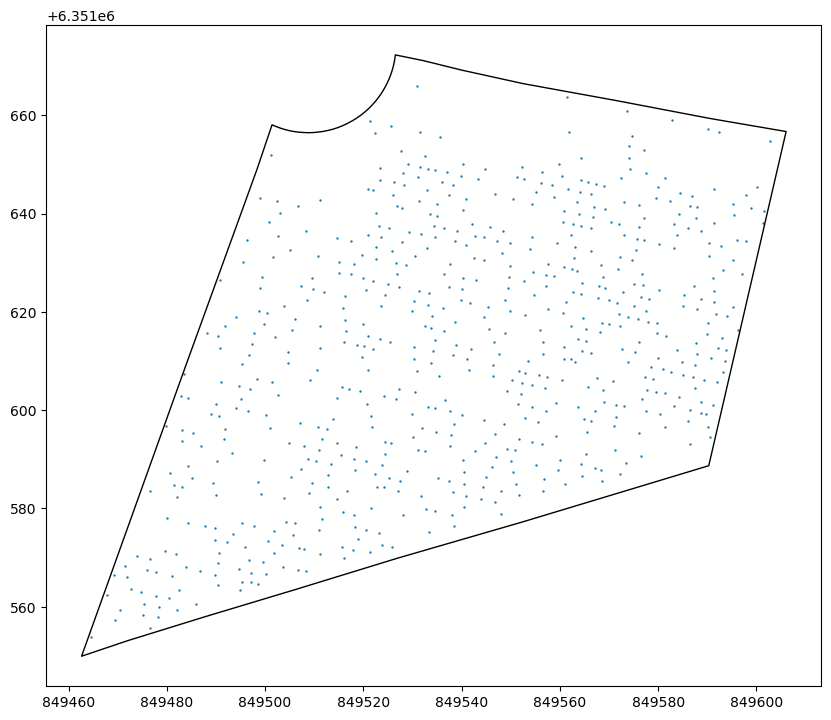

In [111]:
centroids = cluster_points(las_clip, spacing = 0.75, min_points = 3)

# View Output
x_coordinates = centroids[:, 0]
y_coordinates = centroids[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot points
sc = ax.scatter(x_coordinates, y_coordinates, s=0.5)

# Overlay polygon boundary
parcels.boundary.plot(ax=ax, color='black', linewidth=1)

ax.set_aspect('equal')
plt.show()

# Save as Dataframe
data = {'x': centroids[:, 0], 'y': centroids[:, 1], 'z': centroids[:, 2]}
df = pd.DataFrame(data)

### Function That Returns Row Orientation in Degrees
***

In [112]:
# Function returns the angle of crop rows
def find_row_orentation(data, bins = 256):
    
    # Bin points into a 2D image
    hist, xedges, yedges = np.histogram2d(df['x'], df['y'], bins=bins)
    hist = hist.T
    
    # Fourier Transform
    F = np.fft.fftshift(np.fft.fft2(hist))
    magnitude = np.abs(F)
    
    # Remove centeral points 
    cy, cx = np.array(magnitude.shape) // 2
    magnitude[cy, cx] = 0
    
    # Find dominant peak
    peak_y, peak_x = np.unravel_index(np.argmax(magnitude), magnitude.shape)
    
    # Convert frequency into units
    dx = (xedges[-1] - xedges[0]) / bins
    dy = (yedges[-1] - yedges[0]) / bins
    fy = (peak_y - cy) / (bins * dy)
    fx = (peak_x - cx) / (bins * dx)
    
     # Angle of frequency vector
    freq_angle = np.degrees(np.arctan2(fy, fx)) 
    # Angle of line is perpendicular o frquency vector
    line_angle = freq_angle + 90 
    
    return(line_angle)

find_row_orentation(df)

-13.31759302034581

### Plot Showing Single Predicted Line on Points
***

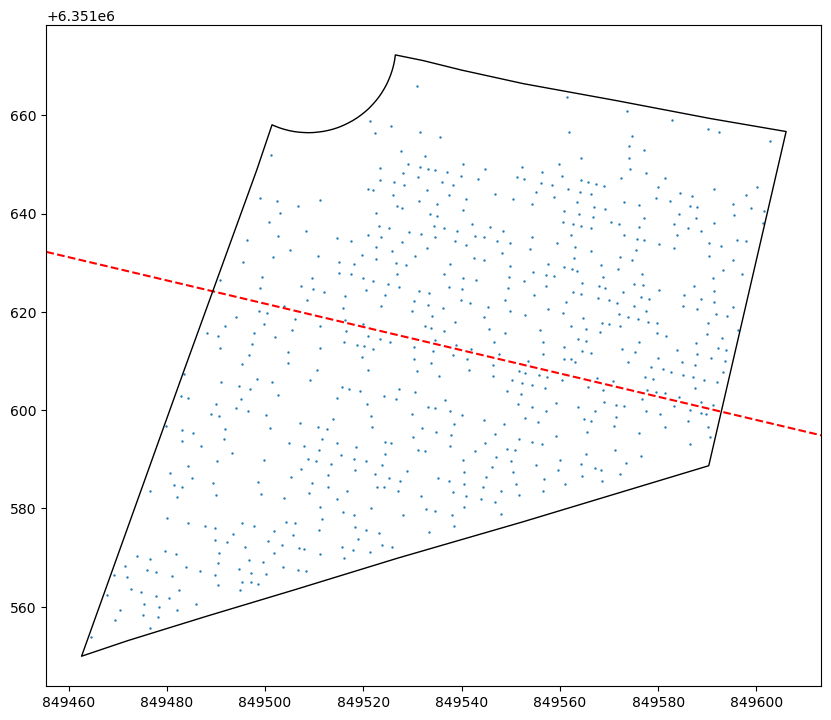

In [114]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot points
sc = ax.scatter(x_coordinates, y_coordinates, s=0.5)

# Use center point to show line
x_mid = np.median(x_coordinates)
y_mid = np.median(y_coordinates)

angle_deg = find_row_orentation(df)
slope = math.tan(math.radians(angle_deg))
ax.axline(xy1=(x_mid, y_mid), slope=slope, color='r', linestyle='--')



# Overlay polygon boundary
parcels.boundary.plot(ax=ax, color='black', linewidth=1)

ax.set_aspect('equal')
plt.show()

# Save as Dataframe
data = {'x': centroids[:, 0], 'y': centroids[:, 1], 'z': centroids[:, 2]}
df = pd.DataFrame(data)